In [3]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras as k
import tensorflow_addons as tfa
import tensorflow.keras.layers as kl
from tensorflow.keras import optimizers 
from tensorflow.keras import regularizers 
from tensorflow.keras import losses 
from tensorflow.keras import metrics as kmetrics
from sklearn import metrics as skmetrics
import matplotlib.pyplot as plt

from IPython.display import clear_output

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

from IPython import display
from datetime import datetime as dt

from data.utils import WindowDataset, WindowDatasetStack

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)
plt.rcParams["figure.figsize"] = (16, 8)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
   # Currently, memory growth needs to be the same across GPUs
   try:
       for gpu in gpus:
           tf.config.experimental.set_memory_growth(gpu, True)
   except RuntimeError as e:
       print(e)

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), markerscale=4, fontsize=18)        
        
%matplotlib inline

/home/vlpr/miniconda3/envs/tfmkl/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:54: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


# Parameters

In [19]:
data_path = os.environ['ENGINE_FAULT_DETECTION_PROJECT_DATA_PATH']
models_path = os.environ['ENGINE_FAULT_DETECTION_PROJECT_MODELS_PATH']

class Bunch:
    __init__ = lambda self, **kw: setattr(self, '__dict__', kw)
args = Bunch()    

args.window_size = 100
args.train_test_split_ratio = 0.9
args.portion = 1.0
args.batch_size = 2**7
args.epochs = 100
args.windows_per_epoch = int(1e6)
args.active_channels = 2
args.initial_learning_rate = 3e-4
args.decay = args.initial_learning_rate / args.epochs
args.warmup_steps = 1

model_name = 'Dense1_1sec_mixed'
simulated_dataset_path = '../../data/4_states_sim.csv'
experiment_dataset_path = '../../data/4_states_exp.csv'

now = dt.now()
log_name = '{}_epochs_{}_{}_{}_{}.h5'.format(model_name, args.epochs, now.day, now.hour, now.minute)
hist_log_name = '{}_epochs_{}_{}_{}_{}.csv'.format(model_name, args.epochs, now.day, now.hour, now.minute)

In [5]:
def noam_based_decay(epoch):
    epoch += 1    
    return args.initial_learning_rate * args.warmup_steps**0.5 * min(epoch**-0.5, epoch*(args.warmup_steps**-1.5)) 

# Dataset

In [4]:
simulated_dataset_description = pd.read_csv(simulated_dataset_path, skipinitialspace=True)
simulated_dataset_description

fp  cid                      name
0                    simulation/07.11.19_nominal.npy    0                 Исправная
1                   simulation/07.11.19_pga_leak.npy    1         Утечка газа в ПГА
2         simulation/09.12.20_fluid_leak_0.600mm.npy    2           Утечка жидкости
3         simulation/09.12.20_fluid_leak_0.625mm.npy    2           Утечка жидкости
4         simulation/09.12.20_fluid_leak_0.650mm.npy    2           Утечка жидкости
5         simulation/09.12.20_fluid_leak_0.675mm.npy    2           Утечка жидкости
6         simulation/09.12.20_fluid_leak_0.700mm.npy    2           Утечка жидкости
7         simulation/09.12.20_fluid_leak_0.725mm.npy    2           Утечка жидкости
8         simulation/09.12.20_fluid_leak_0.750mm.npy    2           Утечка жидкости
9         simulation/09.12.20_fluid_leak_0.775mm.npy    2           Утечка жидкости
10        simulation/09.12.20_fluid_leak_0.800mm.npy    2           Утечка жидкости
11        simulation/09.12.20_fluid_leak_0.825mm.npy    2           Утечка жидкости
12        simulation/09.12.20_fluid_leak_0.850mm.npy    2           Утечка жидкости
13        simulation/09.12.20_fluid_leak_0.875mm.npy    2           Утечка жидкости
14        simulation/09.12.20_fluid_leak_0.900mm.npy    2           Утечка жидкости
15        simulation/09.12.20_fluid_leak_0.925mm.npy    2           Утечка жидкости
16        simulation/25.12.20_fluid_leak_0.940mm.npy    2           Утечка жидкости
17        simulation/09.12.20_fluid_leak_0.950mm.npy    2           Утечка жидкости
18        simulation/09.12.20_fluid_leak_0.975mm.npy    2           Утечка жидкости
19        simulation/09.12.20_fluid_leak_1.000mm.npy    2           Утечка жидкости
20        simulation/09.12.20_fluid_leak_1.025mm.npy    2           Утечка жидкости
21        simulation/09.12.20_fluid_leak_1.050mm.npy    2           Утечка жидкости
22        simulation/09.12.20_fluid_leak_1.075mm.npy    2           Утечка жидкости
23        simulation/09.12.20_fluid_leak_1.100mm.npy    2           Утечка жидкости
24        simulation/09.12.20_fluid_leak_1.125mm.npy    2           Утечка жидкости
25        simulation/09.12.20_fluid_leak_1.150mm.npy    2           Утечка жидкости
26        simulation/25.12.20_fluid_leak_1.160mm.npy    2           Утечка жидкости
27        simulation/09.12.20_fluid_leak_1.175mm.npy    2           Утечка жидкости
28        simulation/09.12.20_fluid_leak_1.200mm.npy    2           Утечка жидкости
29        simulation/09.12.20_fluid_leak_1.225mm.npy    2           Утечка жидкости
30        simulation/09.12.20_fluid_leak_1.250mm.npy    2           Утечка жидкости
31        simulation/09.12.20_fluid_leak_1.275mm.npy    2           Утечка жидкости
32        simulation/09.12.20_fluid_leak_1.300mm.npy    2           Утечка жидкости
33        simulation/09.12.20_fluid_leak_1.325mm.npy    2           Утечка жидкости
34        simulation/09.12.20_fluid_leak_1.350mm.npy    2           Утечка жидкости
35        simulation/25.12.20_fluid_leak_1.365mm.npy    2           Утечка жидкости
36        simulation/09.12.20_fluid_leak_1.375mm.npy    2           Утечка жидкости
37        simulation/09.12.20_fluid_leak_1.400mm.npy    2           Утечка жидкости
38        simulation/09.12.20_fluid_leak_1.425mm.npy    2           Утечка жидкости
39        simulation/09.12.20_fluid_leak_1.450mm.npy    2           Утечка жидкости
40        simulation/09.12.20_fluid_leak_1.475mm.npy    2           Утечка жидкости
41        simulation/09.12.20_fluid_leak_1.500mm.npy    2           Утечка жидкости
42        simulation/09.12.20_fluid_leak_1.525mm.npy    2           Утечка жидкости
43        simulation/09.12.20_fluid_leak_1.550mm.npy    2           Утечка жидкости
44        simulation/25.12.20_fluid_leak_1.560mm.npy    2           Утечка жидкости
45        simulation/09.12.20_fluid_leak_1.575mm.npy    2           Утечка жидкости
46        simulation/09.12.20_fluid_leak_1.600mm.npy    2           Утечка жидкости
47        simulati

In [5]:
experiment_dataset_description = pd.read_csv(experiment_dataset_path, skipinitialspace=True)
experiment_dataset_description

fp  cid                      name
0                    experiment/06.11.19_nominal.npy    0                 Исправная
1   experiment/14.12.20_fluid_leak_nominal_state.npy    0                 Исправная
2    experiment/17.12.20_valve_set_error_nominal.npy    0                 Исправная
3    experiment/31.12.20_valve_set_error_nominal.npy    0                 Исправная
4                   experiment/06.11.19_pga_leak.npy    1         Утечка газа в ПГА
5         experiment/14.12.20_fluid_leak_0.940mm.npy    2           Утечка жидкости
6         experiment/14.12.20_fluid_leak_1.160mm.npy    2           Утечка жидкости
7         experiment/14.12.20_fluid_leak_1.365mm.npy    2           Утечка жидкости
8         experiment/14.12.20_fluid_leak_1.560mm.npy    2           Утечка жидкости
9   experiment/17.12.20_valve_set_error_15.20bar.npy    3  Ошибка настройки клапана
10  experiment/31.12.20_valve_set_error_15.20bar.npy    3  Ошибка настройки клапана
11  experiment/17.12.20_valve_set_error_22.30bar.npy    3  Ошибка настройки клапана
12  experiment/31.12.20_valve_set_error_22.30bar.npy    3  Ошибка настройки клапана
13  experiment/17.12.20_valve_set_error_29.30bar.npy    3  Ошибка настройки клапана
14  experiment/31.12.20_valve_set_error_29.30bar.npy    3  Ошибка настройки клапана
15  experiment/17.12.20_valve_set_error_36.10bar.npy    3  Ошибка настройки клапана
16  experiment/31.12.20_valve_set_error_36.10bar.npy    3  Ошибка настройки клапана

In [6]:
Xsim = WindowDataset(simulated_dataset_path, window_size=args.window_size, initial_shuffle=True, portion=args.portion, active_channels=args.active_channels, verbose=True)
Xexp = WindowDataset(experiment_dataset_path, window_size=args.window_size, initial_shuffle=False, portion=args.portion, active_channels=args.active_channels, verbose=True)
Xmix = WindowDatasetStack(Xsim, Xexp)

../../data/simulation/07.11.19_nominal.npy (3, 999200)
../../data/simulation/07.11.19_pga_leak.npy (3, 999200)
../../data/simulation/09.12.20_fluid_leak_0.600mm.npy (3, 999200)
../../data/simulation/09.12.20_fluid_leak_0.625mm.npy (3, 999200)
../../data/simulation/09.12.20_fluid_leak_0.650mm.npy (3, 999200)
../../data/simulation/09.12.20_fluid_leak_0.675mm.npy (3, 999200)
../../data/simulation/09.12.20_fluid_leak_0.700mm.npy (3, 999200)
../../data/simulation/09.12.20_fluid_leak_0.725mm.npy (3, 999200)
../../data/simulation/09.12.20_fluid_leak_0.750mm.npy (3, 999200)
../../data/simulation/09.12.20_fluid_leak_0.775mm.npy (3, 999200)
../../data/simulation/09.12.20_fluid_leak_0.800mm.npy (3, 999200)
../../data/simulation/09.12.20_fluid_leak_0.825mm.npy (3, 999200)
../../data/simulation/09.12.20_fluid_leak_0.850mm.npy (3, 999200)
../../data/simulation/09.12.20_fluid_leak_0.875mm.npy (3, 999200)
../../data/simulation/09.12.20_fluid_leak_0.900mm.npy (3, 999200)
../../data/simulation/09.12.20_

In [7]:
assert Xsim.class_names == Xexp.class_names
class_names = Xsim.class_names
class_names

{0: 'Исправная',
 1: 'Утечка газа в ПГА',
 2: 'Утечка жидкости',
 3: 'Ошибка настройки клапана'}

In [8]:
Xmix_train_classifier = Xmix.get_generator(
    get_item=lambda cid, w: (w.T, (cid, cid)),
    get_types=lambda: (tf.float32, (tf.int8, tf.int8)),
    get_shape=lambda: (tf.TensorShape([args.window_size, args.active_channels]),  (tf.TensorShape([]), tf.TensorShape([]))),
    train=True, 
    shuffle_windows=True,
    kidx=0,
    train_test_split_ratio=[args.train_test_split_ratio, 0.5])

Xsim_test_classifier, test_labels_true = Xsim.get_generator(
    get_item=lambda cid, w: (w.T, ( cid, cid)),
    get_types=lambda: (tf.float32, ( tf.int8, tf.int8)),
    get_shape=lambda: (tf.TensorShape([args.window_size, args.active_channels]),  ( tf.TensorShape([]), tf.TensorShape([]))),
    train=False, 
    shuffle_windows=True,
    kidx=0,
    train_test_split_ratio=args.train_test_split_ratio,
    return_true_labels=True)

Xexp_test_classifier, experiment_labels_true = Xexp.get_generator(
    get_item=lambda cid, w: (w.T, ( cid, cid)),
    get_types=lambda: (tf.float32, ( tf.int8, tf.int8)),
    get_shape=lambda: (tf.TensorShape([args.window_size, args.active_channels]),  (tf.TensorShape([]), tf.TensorShape([]))),
    train=False, 
    shuffle_windows=False,
    kidx=0,
    return_true_labels=True)

# Model

In [9]:
input_shape = (Xsim.window_size, Xsim.active_channels)

inputs = k.Input(shape=input_shape)

bn = kl.BatchNormalization()(inputs)
fi = kl.Flatten()(bn)

h1 = kl.Dense(3, activation='elu')(fi)

softmax_output = kl.Dense(Xsim.number_of_classes, activation='softmax', name='softmax_layer')(h1)
label_output = kl.Lambda(lambda x: k.backend.argmax(x), name='label_layer')(softmax_output)

classifier_model = k.Model(inputs=inputs, outputs=[softmax_output, label_output])
classifier_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 2)]          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 2)            8         
_________________________________________________________________
flatten (Flatten)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 603       
_________________________________________________________________
softmax_layer (Dense)        (None, 4)                 16        
_________________________________________________________________
label_layer (Lambda)         (None,)                   0         
Total params: 627
Trainable params: 623
Non-trainable params: 4
________________________________________________________

# Train

In [10]:
class History:
    def __init__(self, path):
        self.path = path
        self.train_loss = []
        self.train_classifier_loss = []
        self.train_classifier_acc = []
        
        self.test_loss = []
        self.test_classifier_loss = []
        self.test_classifier_acc = []
        
        self.experiment_loss = []
        self.experiment_classifier_loss = []
        self.experiment_classifier_acc = []

        
    def save_state(self):
        df = pd.DataFrame({i:d[i] for i in self.__dict__ if i != 'path'})
        df.to_csv(self.path, index=False)
    
    def load_state(self):
        df = pd.read_csv(self.path)
        for c in df.columns:
            self.__dict__[c] = df[c].to_list()
        
history = History(hist_log_name)

7:25:41.409187 100/100
train_loss: 0.4039201, test_loss:0.3905249, exp_loss:1.4059561
train_acc: 84.19, test_acc:83.99, test_acc:58.9255691
7813/7813 [==============================] - 261s 33ms/step - loss: 0.4039 - softmax_layer_loss: 0.4039 - softmax_layer_sparse_categorical_accuracy: 0.8419
CPU times: user 8h 10min 39s, sys: 31min 39s, total: 8h 42min 19s
Wall time: 7h 25min 41s


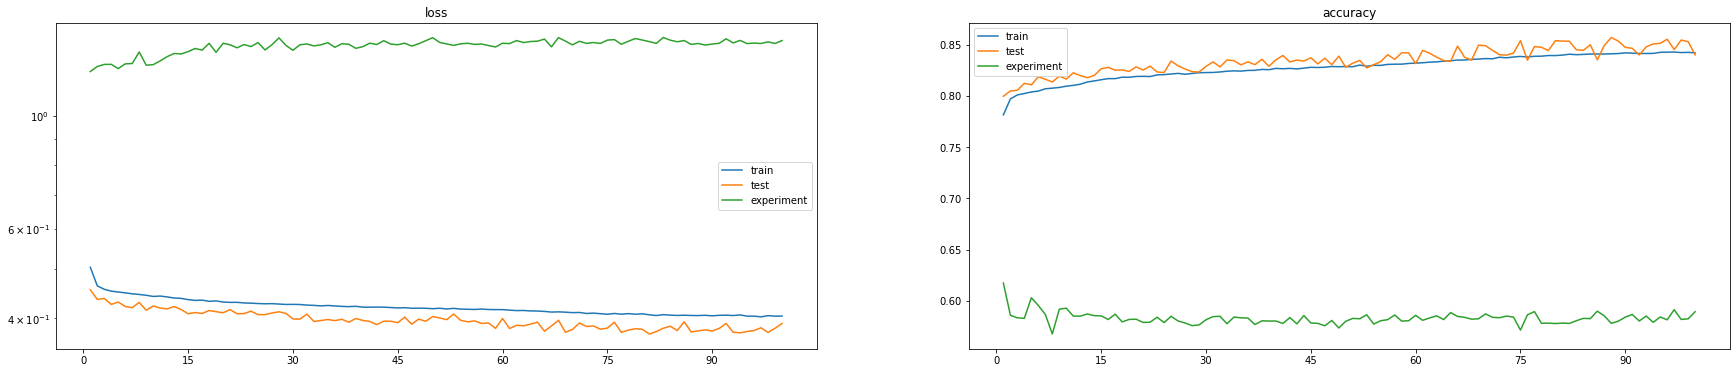

In [11]:
%%time 

start_time = dt.now()

fig, [ax1, ax2] = plt.subplots(1,2, figsize=(30,6), gridspec_kw={'width_ratios':[0.5, 0.5]})

samples = max(10000, int(min(Xsim.number_of_windows*0.1, Xexp.number_of_windows*0.1)))

callbacks = []
class DrawingCallback(k.callbacks.Callback):
    def __init__(self, history):
        self.history = history
        self.train_sample = Xsim_train_classifier.take(samples)
        self.test_sample = Xsim_test_classifier.take(samples)
        self.experiment_sample = Xexp_test_classifier.take(samples)
    
    def on_epoch_end(self, epoch, logs={}):
        train_results = logs
        train_loss, train_classifier_acc = train_results['loss'], train_results['softmax_layer_sparse_categorical_accuracy']
        
        test_results = classifier_model.evaluate(self.test_sample.batch(args.batch_size), return_dict=True)
        test_loss, test_classifier_acc = test_results['loss'], test_results['softmax_layer_sparse_categorical_accuracy']
        
        experiment_results = classifier_model.evaluate(self.experiment_sample.batch(args.batch_size), return_dict=True)
        experiment_loss, experiment_classifier_acc = experiment_results['loss'], experiment_results['softmax_layer_sparse_categorical_accuracy']
        
        self.history.train_loss.append(train_loss)
        self.history.train_classifier_acc.append(train_classifier_acc)
        self.history.test_loss.append(test_loss)
        self.history.test_classifier_acc.append(test_classifier_acc)
        self.history.experiment_loss.append(experiment_loss)
        self.history.experiment_classifier_acc.append(experiment_classifier_acc)
        
        ax1.cla()
        ax2.cla()
        
        ax1.set_title("loss")
        ax2.set_title("accuracy")
        
        ax1.set_yscale('log')
  
        ax1.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax1.plot(range(1, len(self.history.train_loss)+1), self.history.train_loss, label='train')
        ax1.plot(range(1, len(self.history.test_loss)+1), self.history.test_loss, label='test')
        ax1.plot(range(1, len(self.history.experiment_loss)+1), self.history.experiment_loss, label='experiment')
        ax1.legend()        
    
        ax2.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax2.plot(range(1, len(self.history.train_classifier_acc)+1), self.history.train_classifier_acc, label='train')
        ax2.plot(range(1, len(self.history.test_classifier_acc)+1), self.history.test_classifier_acc, label='test')
        ax2.plot(range(1, len(self.history.experiment_classifier_acc)+1), self.history.experiment_classifier_acc, label='experiment')
        ax2.legend()
        

        display.clear_output(wait=True)
        display.display(fig)
        print("{} {}/{}".format(dt.now()-start_time, epoch+1, args.epochs))
        print("train_loss: {:.7f}, test_loss:{:.7f}, exp_loss:{:.7f}".format(self.history.train_loss[-1], 
                                                                             self.history.test_loss[-1],
                                                                             self.history.experiment_loss[-1]))
        print("train_acc: {:.2f}, test_acc:{:.2f}, test_acc:{:.7f}".format(self.history.train_classifier_acc[-1]*100, 
                                                                           self.history.test_classifier_acc[-1]*100,
                                                                           self.history.experiment_classifier_acc[-1]*100))


callbacks.append(DrawingCallback(history))

tensorboard_logs_dir = os.environ['ENGINE_FAULT_DETECTION_PROJECT_LOGS_PATH'] + 'tensorboard/'

log_dir = tensorboard_logs_dir + log_name
callbacks.append(k.callbacks.TensorBoard(log_dir=log_dir + '', histogram_freq=1))

callbacks.append(k.callbacks.LearningRateScheduler(noam_based_decay, verbose=1))
opt = optimizers.Adam(learning_rate=args.initial_learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

classifier_model.compile(optimizer=opt, 
                          loss={'softmax_layer':losses.SparseCategoricalCrossentropy()}, 
                          loss_weights={'softmax_layer':1.0, 'label_layer':0.0},
                          metrics={
                             'softmax_layer': kmetrics.SparseCategoricalAccuracy(),
                          }
                         )

classifier_model.fit(Xmix_train_classifier.take(args.windows_per_epoch).batch(args.batch_size), epochs=args.epochs,  verbose=1, callbacks=callbacks)

In [ ]:
classifier_model.save(models_path + model_name + '_c.h5')

# Test

In [12]:
%%time

test_probs_predicted, test_labels_predicted = classifier_model.predict(Xsim_test_classifier.batch(args.batch_size))

CPU times: user 41min 50s, sys: 2min 42s, total: 44min 33s
Wall time: 38min 53s


In [13]:
%%time

experiment_probs_predicted, experiment_labels_predicted = classifier_model.predict(Xexp_test_classifier.batch(args.batch_size))

CPU times: user 48 s, sys: 2.96 s, total: 51 s
Wall time: 43.8 s


Text(1.0, 1.0, 'Симуляционные данные\n\n                          precision    recall  f1-score   support\n\n               Исправная       0.00      0.00      0.00     99911\n       Утечка газа в ПГА       0.95      0.37      0.53     99911\n         Утечка жидкости       0.85      0.88      0.87   5295283\nОшибка настройки клапана       0.82      0.82      0.82   4396084\n\n                accuracy                           0.84   9891189\n               macro avg       0.66      0.52      0.55   9891189\n            weighted avg       0.83      0.84      0.84   9891189\n')

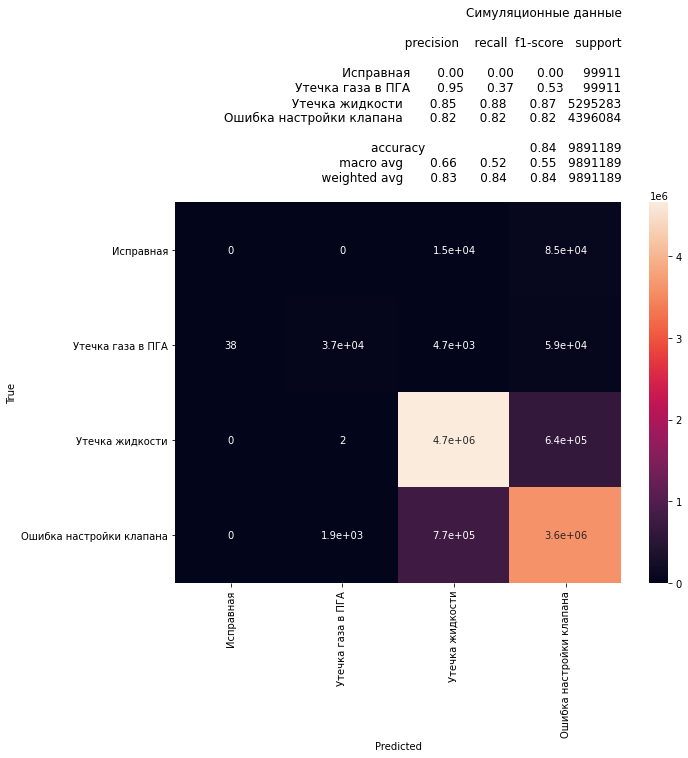

In [16]:
cf = confusion_matrix(test_labels_true, test_labels_predicted, normalize=None)

df_cm = pd.DataFrame(cf, index = class_names.values(), columns = class_names.values())

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.ylabel('True')
plt.gca().set_yticklabels(plt.gca().get_yticklabels(), rotation=0)
plt.xlabel('Predicted')
plt.title("Симуляционные данные\n\n" + classification_report(test_labels_true, test_labels_predicted, target_names=class_names.values()), loc="right")

In [18]:
cf = confusion_matrix(experiment_labels_true, experiment_labels_predicted, normalize=None)

df_cm = pd.DataFrame(cf, index = class_names.values(), columns = class_names.values())

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.ylabel('True')
plt.gca().set_yticklabels(plt.gca().get_yticklabels(), rotation=0)
plt.xlabel('Predicted')
plt.title("Экспериментальные данные\n\n" + classification_report(experiment_labels_true, experiment_labels_predicted, target_names=class_names.values()), loc="right")

Text(1.0, 1.0, 'Экспериментальные данные\n\n                          precision    recall  f1-score   support\n\n               Исправная       0.00      0.00      0.00     50572\n       Утечка газа в ПГА       0.78      0.39      0.52     20872\n         Утечка жидкости       0.40      0.86      0.54     23600\nОшибка настройки клапана       0.54      0.73      0.62     95200\n\n                accuracy                           0.52    190244\n               macro avg       0.43      0.50      0.42    190244\n            weighted avg       0.41      0.52      0.44    190244\n')

In [ ]:
def custom_classification_report(true, predicted, class_names):
    class_labels = sorted(set(true))
    report_rows = []
    for cid in class_labels:
        class_true = true.copy()
        class_true[true!=cid] = 0
        class_true[true==cid] = 1
        class_predicted = predicted.copy()
        class_predicted[predicted!=cid] = 0
        class_predicted[predicted==cid] = 1
        
        accuracy = skmetrics.accuracy_score(class_true, class_predicted)
        balanced_accuracy = skmetrics.balanced_accuracy_score(class_true, class_predicted)
        precision = skmetrics.precision_score(class_true, class_predicted, average='binary')
        recall = skmetrics.recall_score(class_true, class_predicted, average='binary')
        f1 = skmetrics.f1_score(class_true, class_predicted, average='binary')
        mcc = skmetrics.matthews_corrcoef(class_true, class_predicted)
        report_rows.append([accuracy*100, balanced_accuracy*100, precision, recall, f1, mcc])
    
    accuracy = skmetrics.accuracy_score(true, predicted)
    balanced_accuracy = skmetrics.balanced_accuracy_score(true, predicted)
    precision = skmetrics.precision_score(true, predicted, average='macro')
    recall = skmetrics.recall_score(true, predicted, average='macro')
    f1 = skmetrics.f1_score(true, predicted, average='macro')
    mcc = skmetrics.matthews_corrcoef(true, predicted)
    report_rows.append([accuracy*100, balanced_accuracy*100, precision, recall, f1, mcc])
    
    report = pd.DataFrame(
        report_rows, 
        columns=['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1', 'MCC'],
        index=class_names + ['Total'] )
    
    return report

In [ ]:
%%time
custom_classification_report(test_labels_true, test_labels_predicted, class_names=list(class_names.values()))

In [ ]:
%%time
custom_classification_report(experiment_labels_true, experiment_labels_predicted, class_names=list(class_names.values()))